In [ ]:
!pip install ucimlrepo
!pip install pygad

In [2]:
import pandas as pd
import numpy as np
import pygad
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectKBest
import heapq


In [1]:
# Indexes of relevant databases.
ISOLET_DB_INDEX: int = 54
SPAMBASE_DB_INDEX: int = 94

Importing and handling the dataset:

In [62]:
# Read dataset
print("reading isolet")
isolet_db = fetch_ucirepo(id=ISOLET_DB_INDEX)

isolet_features = isolet_db.data.features
isolet_target_variables = isolet_db.data.targets

print("reading spambase")
# Read dataset
spambase_db = fetch_ucirepo(id=SPAMBASE_DB_INDEX)

spambase_features = spambase_db.data.features
spambase_target_variables = spambase_db.data.targets

reading isolet
reading spambase


In [3]:
VERBOSE: bool = False # For more robust error messages
RANDOM_FOREST_SEED: int = 42

db = [isolet_db, spambase_db]
features = [isolet_features, spambase_features]
target_variables = [isolet_target_variables, spambase_target_variables]

FEATURES_TO_SELECT = [5, 40]

TEST_TRAIN_SPLIT = 0.2
RANDOM_STATE_OF_DATA_SPLIT = 42

# Genetic Algorithm parameters
NUMBER_OF_GENERATIONS = [1, 5, 20]
NUMBER_OF_PARENTS_MATING = 4

SOLUTIONS_PER_POPULATION = 12
NUMBER_OF_GENES = 5 # Use this to control the number of feature selection potential solutions is used.

INIT_RANGE_LOW = 0
INIT_RANGE_HIGH = 1

PARENT_SELECTION_TYPE = ["sss", "rank"] #steady-state selection, meaning it selects the parents with the highest fitness.
KEEP_PARENTS = 1

CROSSOVER_TYPE = "single_point" # Swaps the chromosomes from a certain index onwards between the parents.

MUTATION_TYPE = "random"
MUTATION_PERCENT_GENES = 20

In [5]:
# Print missing values and maximum and minimum values in the features of the first dataset
X_df = pd.DataFrame(features)
y_df = pd.DataFrame(target_variables)

print("Missing values in X:", X_df.isnull().sum().sum())
print("Missing values in y:", y_df.isnull().sum().sum())

print("Minimum value across all features:", X_df.min().min())
print("Maximum value across all features:", X_df.max().max())

Missing values in X: 0
Missing values in y: 0
Minimum value across all features: -1.0
Maximum value across all features: 1.0


In [6]:
# Normalize the dataset
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_df)

X_scaled_df = pd.DataFrame(X_scaled, columns=X_df.columns)

print(X_scaled_df.min().min())
print(X_scaled_df.max().max())

0.0
1.0000000000000002


In [7]:
data_after_scaling = X_scaled_df
target_variables = y_df.values.ravel()

Feature selection functions

In [8]:
def get_top_k_features(selector,
                       feature_names: list,
                       top_features_to_select: int,
                       algorithm: str,
                       verbose: bool = False,
                       normalize_score: bool = True):
  """
  Get the top k features based on their scores from a SelectKBest selector.

  Parameters:
  selector (SelectKBest): Fitted SelectKBest object.
  feature_names (list): List of feature names (columns of X).
  k (int): Number of top features to select.
  algorithm (str): The name of the feature selection algorithm.
  verbose (bool): Decide whether to print model results or not.
  normalize_score (bool): Decide whether to normalize the score or not.


  Returns:
  A dataframe that contains 2 columns: The first is "Feature" and is the feature name and the second is a score, normalization is dependent on the var sent..

  """
  # Retrieve feature scores
  scores = selector.scores_

  if normalize_score:
      scores = scores / np.nansum(scores)

  feature_ranking = pd.DataFrame({
    'Feature': feature_names,
    'Score': scores
  }).sort_values(by='Score', ascending=False)
  if verbose:
    # Display top-ranked features
    print(f"Feature Rankings using {algorithm}:")
    print(feature_ranking)


  # Return selected top k features
  return feature_ranking.head(top_features_to_select)

In [10]:
def train_and_fit_random_forest(X_train, X_test, y_train, y_test, verbose: bool = VERBOSE):
  """
  Builds, trains, and evaluates a Random Forest classification model.

  Parameters:
  ----------
  X_train : pd.DataFrame or np.ndarray
      Feature matrix for training the model.
  X_test : pd.DataFrame or np.ndarray
      Feature matrix for testing the model.
  y_train : pd.Series or np.ndarray
      Target labels for training the model.
  y_test : pd.Series or np.ndarray
      True target labels for testing the model.
  verbose (bool): Decide whether to print model results or not

  Returns:
  float: The accuracy of the model on the selected features
  """
  # Build a simple classification model
  model = RandomForestClassifier(random_state=RANDOM_FOREST_SEED)
  model.fit(X_train, y_train)

  # Make predictions
  y_pred = model.predict(X_test)

  # Evaluate the model
  accuracy = accuracy_score(y_test, y_pred)
  if verbose:
    print("Model Accuracy:", accuracy)
    # Detailed performance metrics
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

  # Return the accuracy of the model
  return accuracy


Import all the feature selection algorithms.

In [12]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import f_regression

mutual_info_classif_with_random_state = lambda X, y: mutual_info_classif(X, y, random_state=42)
mutual_info_regression_with_random_state = lambda X, y: mutual_info_regression(X, y, random_state=42)

# Selects features based on the k best scores. Here k is 'all'.
classifier_chi2: SelectKBest = SelectKBest(score_func=chi2, k='all')
classifier_mutual_info_classif: SelectKBest = SelectKBest(score_func=mutual_info_classif_with_random_state, k='all')
classifier_mutual_info_regression: SelectKBest = SelectKBest(score_func=mutual_info_regression_with_random_state, k='all')
classifier_f_classif: SelectKBest = SelectKBest(score_func=f_classif, k='all')
classifier_f_regression: SelectKBest = SelectKBest(score_func=f_regression, k='all')

Preselecting all the features with each classifier to get a feature ranking.

In [14]:
# Fits all the feature selection algorithms.

selector_list = [
    (classifier_chi2, "classifier_chi2"),
    (classifier_mutual_info_classif, "classifier_mutual_info_classif"),
    (classifier_mutual_info_regression, "classifier_mutual_info_regression"),
    (classifier_f_classif, "classifier_f_classif"),
    (classifier_f_regression, "classifier_f_regression")
]
features_selected_by_each_algorithm: dict = dict()
for selector_in_list in selector_list:
    selector_in_list: tuple[SelectKBest, str]
    selector_in_list[0].fit(data_after_scaling, target_variables)
      # Rank the features using Chi-Square algorithm
    top_features = get_top_k_features(
        selector=selector_in_list[0],
        feature_names=features.columns,
        top_features_to_select=len(features.columns), #todo change back?
        algorithm=selector_in_list[1],
    )
    features_selected_by_each_algorithm[selector_in_list[1]] = top_features


In [15]:
def weighted_combine_feature_scores(features_selected_by_each_algorithm_in_func: dict[str, pd.DataFrame],
                                    weights: list[float],
                                    verbose: bool = VERBOSE) -> pd.DataFrame:
    """
    Sums all the features selected by each algorithm, multiplying each feature by the weight corresponding to its index.
    :param features_selected_by_each_algorithm_in_func:
    :param weights:
    :param verbose: Printing relevant messages.
    :return:
    """
    if len(features_selected_by_each_algorithm_in_func) != len(weights):
        raise ValueError("Number of weights does not match number of features selectors")
    combined_scores = pd.DataFrame({
        'Feature': [],
        'Score': []
    })
    index = 0
    for algorithm_name, features_selected_by_algorithm in features_selected_by_each_algorithm_in_func.items():
        if verbose:
            print(f'Combining scores for {algorithm_name}, its weight is: {weights[index]}')

        features_selected_by_algorithm['Score'] = features_selected_by_algorithm['Score'] * weights[index]
        combined_scores = pd.merge(combined_scores,
                               features_selected_by_algorithm,
                               on='Feature', how='outer', suffixes=('_df1', '_df2'))

        # Sum the scores where both exist, fill NaN with 0 for features that only exist in one of the dataframes
        combined_scores['Score'] = combined_scores['Score_df1'].fillna(0) + combined_scores['Score_df2'].fillna(0)

        # Drop the original score columns if not needed
        combined_scores = combined_scores[['Feature', 'Score']]
        index += 1
    return combined_scores

Genetic Algorithm part, will use the cells created above.

Running the genetic algorithm, using the other feature selection methods

In [18]:
def fitness_func_as_weights_to_use_from_each_algorithm(ga_instance, solution, solution_idx):
    combined_scores = weighted_combine_feature_scores(features_selected_by_each_algorithm_in_func=features_selected_by_each_algorithm,
                                                      weights=solution)
    combined_sorted_scores = combined_scores.sort_values(by=['Score'], ascending=False)
    list_of_sorted_features = combined_sorted_scores.head(FEATURES_TO_SELECT)['Feature'].tolist()
    data_with_top_features = data_after_scaling[list_of_sorted_features]

    X_train, X_test, y_train, y_test = train_test_split(data_with_top_features, target_variables, test_size=TEST_TRAIN_SPLIT, random_state=RANDOM_STATE_OF_DATA_SPLIT)
    # Train and fit random forest classification model based on feature selected
    accuracy = train_and_fit_random_forest(X_train, X_test, y_train, y_test)
    if VERBOSE:
        print(f'model_accuracy: {accuracy}')
    return accuracy

In [63]:
NUMBER_OF_GENERATIONS

1

In [82]:
fitness_values = []
# Define a callback function to save fitness values at each generation
def save_fitness_at_generation(ga_instance, my_l):
    my_l.append(ga_instance.best_solution()[1])

In [83]:
my_l = []
ga_instance_feature_selection_algorithms = (
    pygad.GA(num_generations=2,
             num_parents_mating=NUMBER_OF_PARENTS_MATING,  # Num of parents to select each generation.
             fitness_func=fitness_func_as_weights_to_use_from_each_algorithm,
             sol_per_pop=SOLUTIONS_PER_POPULATION,  # Number of solutions per population.
             num_genes=NUMBER_OF_GENES,  # Effectively, the thing that is tweaked for each generation.
             # gene_type=list[float], # The type of gene, meaning of each value inside a chromosome. Supports list.
             init_range_low=INIT_RANGE_LOW,  # dependent on the gene type, the range of values to be generated.
             init_range_high=INIT_RANGE_HIGH,
             parent_selection_type=PARENT_SELECTION_TYPE,
             keep_parents=KEEP_PARENTS,  # Number of parents to keep from current population.
             # keep_elitism = 1, # The number of the solutions with the best fitness that will be kept for next generation.
             crossover_type=CROSSOVER_TYPE,
             mutation_type=MUTATION_TYPE,
             mutation_by_replacement=True,  # If the previous gene is replaced or not.
             mutation_percent_genes=MUTATION_PERCENT_GENES,  # The probability that each gene will be mutated
             # crossover_type=crossover_func, Can be used to customize a crossover func.
             # mutation_type=mutation_func, Can be used to customize a mutation func.
             on_generation=lambda x: save_fitness_at_generation(x, my_l)
             )
)

ga_instance_feature_selection_algorithms.run()
print('Running feature selection based on other feature selection algorithms')
print('--------------------------------------------------')
print(f'Generation: {NUMBER_OF_GENERATIONS}')
solution, solution_fitness, solution_idx = ga_instance_feature_selection_algorithms.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
my_l.append(solution_fitness)
my_l

Running feature selection based on other feature selection algorithms
--------------------------------------------------
Generation: 1
Parameters of the best solution : [-0.19416223  0.24143723  0.14662245  0.98331885  0.32602878]
Fitness value of the best solution = 0.35384615384615387


[np.float64(0.3269230769230769),
 np.float64(0.3641025641025641),
 np.float64(0.35384615384615387)]

C:\Users\travkaie\OneDrive - Intel Corporation\Documents\Projects\research-methods-class\.venv\Lib\site-packages\pygad\visualize\plot.py:120: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  matplt.legend()


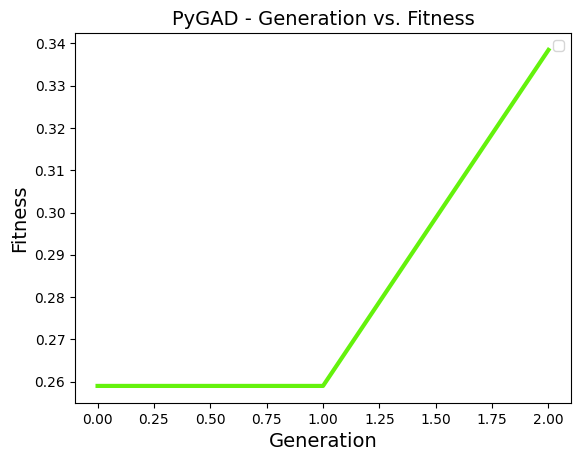

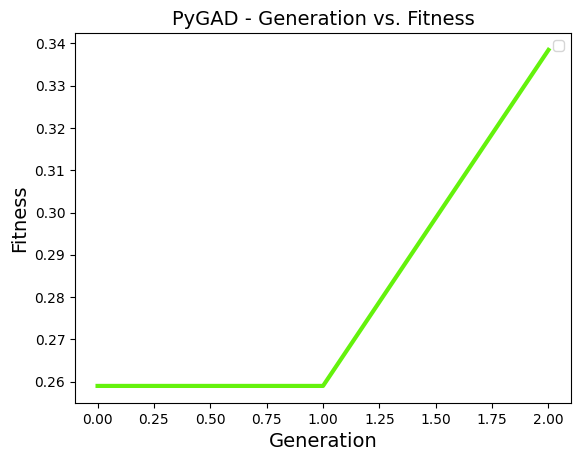

In [78]:
ga_instance_feature_selection_algorithms.plot_fitness()

In [79]:
my_l.append(solution_fitness)
my_l

[0.258974358974359, 0.258974358974359, np.float64(0.3384615384615385)]

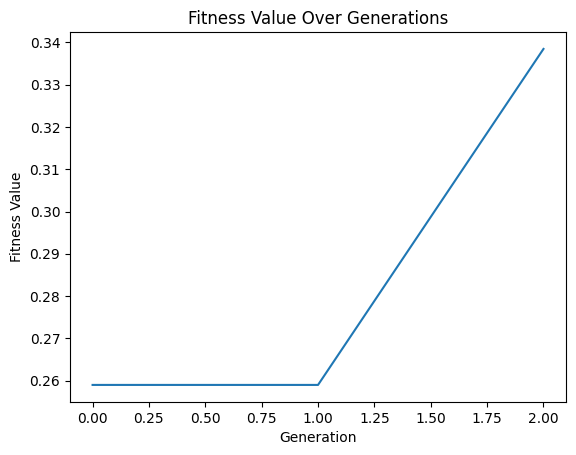

In [81]:
from matplotlib import pyplot as plt

# Create a line plot
plt.plot(my_l)

# Add labels and title (optional but recommended for clarity)
plt.xlabel("Generation")
plt.ylabel("Fitness Value")
plt.title("Fitness Value Over Generations")
# Display the plot
plt.show()

binary weights for each fs algorithm

In [ ]:
ga_instance_selecting_features_directly = (
    pygad.GA(num_generations=NUMBER_OF_GENERATIONS,
             num_parents_mating=NUMBER_OF_PARENTS_MATING,  # Num of parents to select each generation.
             fitness_func=fitness_func_as_weights_to_use_from_each_algorithm,
             sol_per_pop=SOLUTIONS_PER_POPULATION,  # Number of solutions per population.
             num_genes=NUMBER_OF_GENES,  # Effectively, the thing that is tweaked for each generation.
             # gene_type=list[float], # The type of gene, meaning of each value inside a chromosome. Supports list.
             init_range_low=INIT_RANGE_LOW,  # dependent on the gene type, the range of values to be generated.
             init_range_high=INIT_RANGE_HIGH,
             parent_selection_type=PARENT_SELECTION_TYPE,
             keep_parents=KEEP_PARENTS,  # Number of parents to keep from current population.
             # keep_elitism = 1, # The number of the solutions with the best fitness that will be kept for next generation.
             crossover_type=CROSSOVER_TYPE,
             mutation_type=MUTATION_TYPE,
             mutation_by_replacement=True,  # If the previous gene is replaced or not.
             mutation_percent_genes=MUTATION_PERCENT_GENES,  # The probability that each gene will be mutated
             # crossover_type=crossover_func, Can be used to customize a crossover func.
             # mutation_type=mutation_func, Can be used to customize a mutation func.
             gene_space= [[0,1] for _ in range(NUMBER_OF_GENES)]
             )
)

ga_instance_selecting_features_directly.run()
print('Running feature selection based on simple binary weighted genetic algorithm')
print('--------------------------------------------------')
print(f'Generation: {NUMBER_OF_GENERATIONS}')
solution, solution_fitness, solution_idx = ga_instance_selecting_features_directly.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

Running the genetic algorithm (With the same parameters as the previous genetic algorithm) but selecting the features directly.



In [57]:
def fitness_func_on_features_themselves(ga_instance, solution, solution_idx):
    # raise NotImplementedError("Please implement selecting a feature based on the solution array")
    top_n_indexes = [index for value, index in heapq.nlargest(FEATURES_TO_SELECT, [(val, idx) for idx, val in enumerate(solution)], key=lambda x: x[0])]
    filtered_list = [elem for i, elem in enumerate(features) if i in top_n_indexes]
    filtered_df_list = data_after_scaling[filtered_list]

    X_train, X_test, y_train, y_test = train_test_split(filtered_df_list, target_variables, test_size=TEST_TRAIN_SPLIT, random_state=RANDOM_STATE_OF_DATA_SPLIT)
    # Train and fit random forest classification model based on feature selected
    accuracy = train_and_fit_random_forest(X_train, X_test, y_train, y_test)
    if VERBOSE:
        print(f'model_accuracy: {accuracy}')

    #penalty if too many features are selected
    # num_selected_features = sum(solution)
    # if num_selected_features > FEATURES_TO_SELECT:
    #     accuracy/=num_selected_features
    return accuracy

In [54]:
NUMBER_OF_POSSIBLE_FEATURES: int = len(features.columns) # <--- Add info here.
# GENE_VALUES: list = [0, 1]

In [55]:
gene_space = list(range(NUMBER_OF_POSSIBLE_FEATURES))

In [60]:
ga_instance_selecting_features_directly = (
    pygad.GA(num_generations=NUMBER_OF_GENERATIONS,
             num_parents_mating=NUMBER_OF_PARENTS_MATING,  # Num of parents to select each generation.
             fitness_func=fitness_func_on_features_themselves,
             sol_per_pop=SOLUTIONS_PER_POPULATION,  # Number of solutions per population.
             num_genes=NUMBER_OF_POSSIBLE_FEATURES,  # Effectively, the thing that is tweaked for each generation.
             # gene_type=list[float], # The type of gene, meaning of each value inside a chromosome. Supports list.
             init_range_low=INIT_RANGE_LOW,  # dependent on the gene type, the range of values to be generated.
             init_range_high=INIT_RANGE_HIGH,
             parent_selection_type=PARENT_SELECTION_TYPE,
             keep_parents=KEEP_PARENTS,  # Number of parents to keep from current population.
             # keep_elitism = 1, # The number of the solutions with the best fitness that will be kept for next generation.
             crossover_type=CROSSOVER_TYPE,
             mutation_type=MUTATION_TYPE,
             mutation_by_replacement=True,  # If the previous gene is replaced or not.
             mutation_percent_genes=MUTATION_PERCENT_GENES,  # The probability that each gene will be mutated
             # crossover_type=crossover_func, Can be used to customize a crossover func.
             # mutation_type=mutation_func, Can be used to customize a mutation func.
             gene_space=gene_space
             )
)

ga_instance_selecting_features_directly.run()
print('Running feature selection based on simple genetic algorithm')
print('--------------------------------------------------')
print(f'Generation: {NUMBER_OF_GENERATIONS}')
solution, solution_fitness, solution_idx = ga_instance_selecting_features_directly.best_solution()
solution_limited = [index for value, index in heapq.nlargest(FEATURES_TO_SELECT, [(val, idx) for idx, val in enumerate(solution)], key=lambda x: x[0])]
print("Parameters of the best solution : {solution}".format(solution=solution_limited))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

Running feature selection based on simple genetic algorithm
--------------------------------------------------
Generation: 1
Parameters of the best solution : [349, 105, 10, 7, 290]
Fitness value of the best solution = 0.3974358974358974


Training the model with the features selected by each algorithm individually to achieve ablation study.

In [23]:
# Checking the performance of the features selected by each model independently.

for feature_selection_method_name, features_selected_with_score in features_selected_by_each_algorithm.items():
    features_selected_by_algorithm = features_selected_with_score.head(FEATURES_TO_SELECT)['Feature'].tolist()
    data_after_selecting_features = data_after_scaling[features_selected_by_algorithm]
    X_train, X_test, y_train, y_test = train_test_split(data_after_selecting_features, target_variables, test_size=TEST_TRAIN_SPLIT, random_state=42)
    accuracy = train_and_fit_random_forest(X_train, X_test, y_train, y_test)
    print('------------------------------------------------')
    print(f'Feature selection method: {feature_selection_method_name}. Accuracy: {accuracy}')

------------------------------------------------
Feature selection method: classifier_chi2. Accuracy: 0.20064102564102565
------------------------------------------------
Feature selection method: classifier_mutual_info_classif. Accuracy: 0.3269230769230769
------------------------------------------------
Feature selection method: classifier_mutual_info_regression. Accuracy: 0.3121794871794872
------------------------------------------------
Feature selection method: classifier_f_classif. Accuracy: 0.23333333333333334
------------------------------------------------
Feature selection method: classifier_f_regression. Accuracy: 0.258974358974359
